In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import cactas as C

In [3]:
import torch
from torchvision import models
from torchvision.transforms import transforms
from monai.networks.nets import UNet

In [4]:
DATAPATH='/raid/mpsych/CACTAS/DATA/ESUS'

In [5]:
images, labels = C.Helper.load_data(DATAPATH)

In [6]:
X_train, y_train, X_test, y_test = C.Helper.split_patients(images, labels)

In [7]:
X_train, y_train, X_test, y_test = C.Helper.normalization(DATAPATH, X_train, y_train, X_test, y_test)

In [8]:
X_train[0].shape

(512, 512, 293)

In [9]:
def pad(image, label):
    maxX = 512
    maxY = 512
    maxZ = 400
    slicecount = 0
    
    padded_images = np.zeros((slicecount, maxY, maxX, maxZ), dtype=image[0].dtype)
    padded_labels = np.zeros((slicecount, maxY, maxX, maxZ), dtype=label[0].dtype)

    img = image
    lbl = label
        
        # Calculate the amount of padding needed
    pad_x = maxX - img.shape[1]
    pad_y = maxY - img.shape[0]
    pad_z = maxZ - img.shape[2]
    print("-----------------------")
    print(pad_x)
    print(pad_z)
        
        # Pad the image and label
    padded_img = np.pad(img, ((0, pad_y), (0, pad_x), (0, pad_z)), 'constant')
    padded_lbl = np.pad(lbl, ((0, pad_y), (0, pad_x), (0, pad_z)), 'constant')
    print("-----------------------")
    print(padded_img)
    padded_images = padded_img
    padded_labels = padded_lbl
        
    return padded_images, padded_labels

In [10]:
padded_image, padded_label = pad(X_train[0], y_train[0])

-----------------------
0
107
-----------------------
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0

In [11]:
padded_image.shape, padded_label.shape

((512, 512, 400), (512, 512, 400))

In [12]:
target_size = (256, 256)

In [13]:
# Convert to PyTorch tensor
image_tensor = torch.from_numpy(padded_image.transpose((2, 0, 1))).float()  # Transpose to (C, H, W)

In [14]:
# You may need to unsqueeze the tensor to add a batch dimension (B, C, H, W) if working with a single image
image_tensor = image_tensor.unsqueeze(0)

In [15]:
# Define the resize transformation for tensors
resize_transform = transforms.Resize(size=target_size, interpolation=transforms.InterpolationMode.BILINEAR)

In [16]:
# Apply the resize transformation
image_resized_tensor = resize_transform(image_tensor)

In [17]:
# Squeeze back if necessary
image_resized_tensor = image_resized_tensor.squeeze(0)

In [18]:
image_resized_tensor.shape

torch.Size([400, 256, 256])

In [19]:
label_tensor = torch.from_numpy(padded_label.transpose((2, 0, 1))).float()  # Transpose to (C, H, W)
label_tensor = label_tensor.unsqueeze(0)
resize_transform = transforms.Resize(size=target_size, interpolation=transforms.InterpolationMode.BILINEAR)
label_resized_tensor = resize_transform(label_tensor)
label_resized_tensor = label_resized_tensor.squeeze(0)

In [20]:
label_resized_tensor.shape

torch.Size([400, 256, 256])

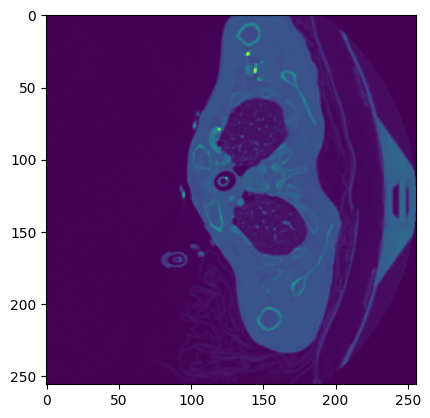

In [21]:
plt.imshow(image_resized_tensor[80,:,:])
plt.show()

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
weights = 'seg_model_weights.pth'

In [24]:
model = UNet(spatial_dims=3,
              in_channels=1,
              out_channels=3,
              channels=(16, 32, 64, 128),  
              strides=(2, 2, 2),
              num_res_units=3,
              norm='INSTANCE',
              ).to(device)

In [25]:
model.load_state_dict(torch.load(weights, map_location=device))

<All keys matched successfully>

In [26]:
model.eval()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit2): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(16, eps=1e-05, momentum=0.1, aff

In [27]:
print(np.array(image_resized_tensor))

[[[0.0000000e+00 0.0000000e+00 6.1050065e-05 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 1.2210013e-04 2.4420026e-04 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [1.8315020e-04 1.8315020e-04 8.5470086e-04 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  ...
  [0.0000000e+00 6.1050065e-05 2.4420025e-03 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]]

 [[0.0000000e+00 6.1050065e-05 1.2210013e-04 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 1.2210013e-04 2.4420026e-04 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [1.8315020e-04 2.4420026e-04 1.2820513e-03 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  ...
  [1.2210013e-04 1.2210013e-04 2.1978023e-03 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [6.1050065e-05 0.0000000e+00 0.000

In [28]:
X_test_tensor = torch.from_numpy(np.array(image_resized_tensor)).float()  # Convert inputs to PyTorch tensors and ensure the type is float
y_test_tensor = torch.from_numpy(np.array(label_resized_tensor)).long()  # Targets/labels typically need to be of type long

In [29]:
#X_test_tensor = torch.transpose(X_test_tensor, 3, 1)

In [30]:
X_test_tensor.size(), y_test_tensor.size()

(torch.Size([400, 256, 256]), torch.Size([400, 256, 256]))

In [31]:
outputs = model(torch.ones((1, 1, 400, 256, 256)))

In [32]:
#for idx, x in enumerate(X_test_tensor):
x = torch.tensor(X_test_tensor).float()
print(x.size())
outputs = model(x.unsqueeze(0).unsqueeze(0))
print(outputs)

/tmp/ipykernel_3279315/2169509285.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(X_test_tensor).float()


torch.Size([400, 256, 256])
tensor([[[[[ 1.7748,  2.4537,  2.5608,  ...,  2.4783,  2.5525,  1.8254],
           [ 4.1254,  4.7211,  5.4290,  ...,  5.0602,  5.9700,  3.5947],
           [ 2.5894,  3.9343,  3.9269,  ...,  3.8560,  3.9847,  2.9281],
           ...,
           [ 4.3310,  4.4685,  5.4181,  ...,  5.0166,  5.8669,  3.5008],
           [ 2.4673,  3.5942,  3.7983,  ...,  3.6795,  3.7513,  2.7251],
           [ 3.0029,  3.9433,  3.9420,  ...,  4.0087,  3.8606,  2.8226]],

          [[ 2.8357,  4.6697,  4.1384,  ...,  4.9713,  4.4345,  3.7844],
           [ 4.7621,  6.9150,  6.9206,  ...,  7.3870,  7.2703,  4.1959],
           [ 4.2423,  6.2193,  6.2455,  ...,  6.6749,  6.9877,  5.5404],
           ...,
           [ 4.8131,  6.5432,  6.3177,  ...,  7.3638,  7.0111,  4.0960],
           [ 4.0957,  6.1844,  5.9461,  ...,  6.4545,  6.3784,  5.0188],
           [ 3.2779,  4.8002,  4.7989,  ...,  4.9162,  4.9295,  2.9056]],

          [[ 3.0029,  4.2384,  4.4516,  ...,  4.2439,  4.477

In [33]:
with torch.no_grad():
    x = torch.tensor(X_test_tensor).float()
    outputs = model(x.unsqueeze(0).unsqueeze(0))
    #outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    total = y_test_tensor.size(0)
    correct = (predicted == y_test_tensor).sum().item()
    test_acc = correct / total

/tmp/ipykernel_3279315/2308084170.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(X_test_tensor).float()


In [34]:
test_acc

60081.03

In [35]:
correct

24032412

In [71]:
pred_np = predicted.detach().cpu().numpy()[0]

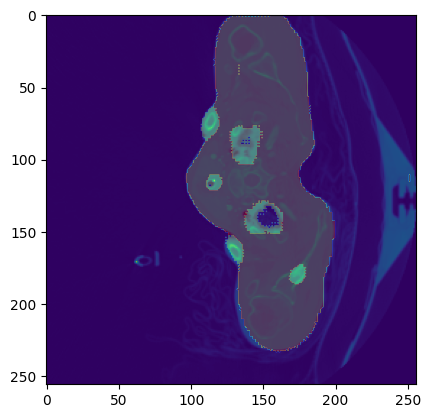

In [79]:
plt.imshow(X_test_tensor[98,:,:])
plt.imshow(pred_np[98], cmap='jet', alpha=0.3)  # Using gray scale color map for visualization
#plt.axis('off')  # Optional: to hide axes for better visualization
plt.show()